In [109]:
import torch 
from stimulus import *
from BIRNN import *
import matplotlib.pyplot as plt 
from tqdm import trange

%matplotlib inline
memory_size = 128
in_emb = memory_size//4
mem_lay = 1
inputs_dim = 2
decisions = 3
typeCell = 'BRC'

sensor = ResMLP(inputs_dim, in_emb, [64,64,64])
actor = ResMLP(memory_size, decisions, [64,64,64])

model = SenseMemAct(sensor, actor, in_sz=in_emb, mem_sz=memory_size, 
                    mem_lay=mem_lay, decisions=decisions, type = typeCell)

Model has 72419 parameters


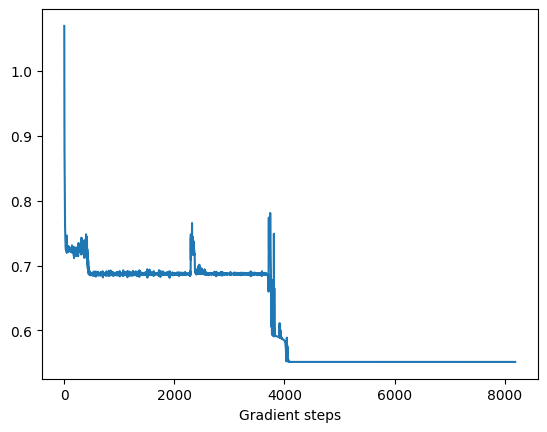

In [110]:
# load model
modelfname = f'./results_train/checkpoint_{typeCell}.pth'
lossfname = f'./results_train/loss_{typeCell}.pt'
state = torch.load(modelfname, map_location=torch.device('cpu'))
loss = torch.load(lossfname, map_location=torch.device('cpu'))
model.load_state_dict(state)
print('Model has',torch.sum(torch.tensor([p.numel() for p in model.parameters()])).item(), 'parameters')
plt.plot(loss)
plt.xlabel('Gradient steps')
plt.show()

In [111]:
print(model.mem, model.sense, model.act, sep = '\n\n')

nBRC(
  (ff_im): Linear(in_features=32, out_features=384, bias=False)
  (ff_mm): Linear(in_features=128, out_features=256, bias=False)
)

ResMLP(
  (head): Linear(in_features=2, out_features=64, bias=True)
  (layers): ModuleList(
    (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
  )
  (tail): Linear(in_features=64, out_features=32, bias=True)
  (activ): ReLU()
)

ResMLP(
  (head): Linear(in_features=128, out_features=64, bias=True)
  (layers): ModuleList(
    (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
  )
  (tail): Linear(in_features=64, out_features=3, bias=True)
  (activ): ReLU()
)


In [112]:
# # weights of the linear layer that combines memory 'h' to produce bifurcation parameter 'a'
# if typeCell != 'GRU':
#     for i in range(2):
#     # print(model.mem.ff_ha.weight.shape)
#         im_w_mat = model.mem.ff_mm.weight.detach()[memory_size*i:memory_size*(i+1)]
#         plt.imshow(im_w_mat)
#         plt.show()

#         u,s,v = torch.linalg.svd(im_w_mat)
#         plt.scatter(torch.arange(len(s)), s)
#         plt.ylabel('Ordered singular values')
#         plt.show()

#         s[3:] = 0
#         plt.imshow(u@torch.diag(s)@v)
#         with torch.no_grad():
#             model.mem.ff_mm.weight[memory_size*i:memory_size*(i+1)] = u@torch.diag(s)@v

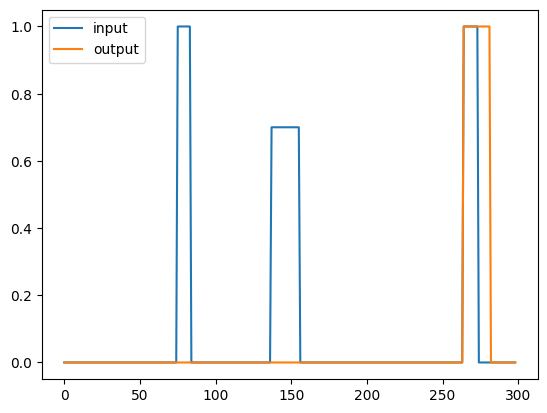

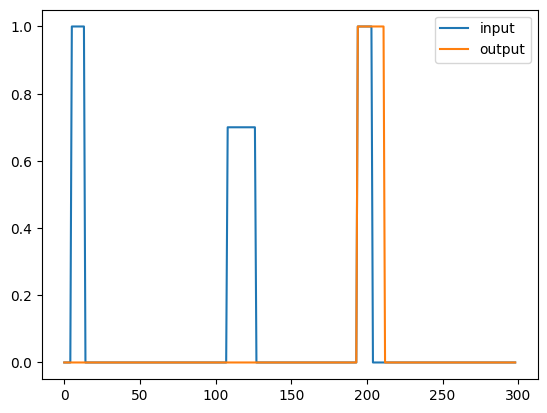

In [113]:
stimG = StimGenerator(dt=.1)
d_i, d_o = stimG.get_batch_data(2)
d_i, d_o = stimG.extend_sim(30, d_i, d_o)
# d_i, d_o = stimG.concat_sim(d_i, d_o)

plt.plot(d_i[0], label = 'input')
plt.plot(d_o[0], label = 'output')
plt.legend()
plt.show()

plt.plot(d_i[1], label = 'input')
plt.plot(d_o[1], label = 'output')
plt.legend()
plt.show()

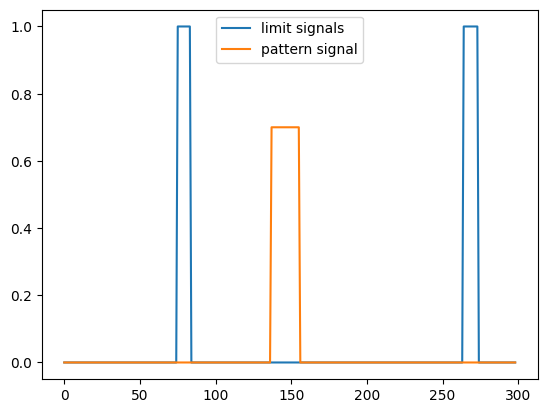

In [114]:
B, L = d_i.shape
mod_in = torch.zeros((B,L,2))
mod_in[...,0][d_i == 1] = 1
mod_in[...,1][d_i != 1] = d_i[d_i!=1]
plt.plot(mod_in[0,:,0], label = 'limit signals')
plt.plot(mod_in[0,:,1], label = 'pattern signal')
plt.legend()
plt.show()
# pred = model()

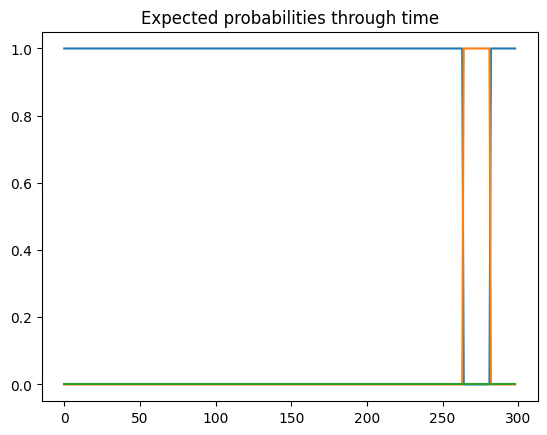

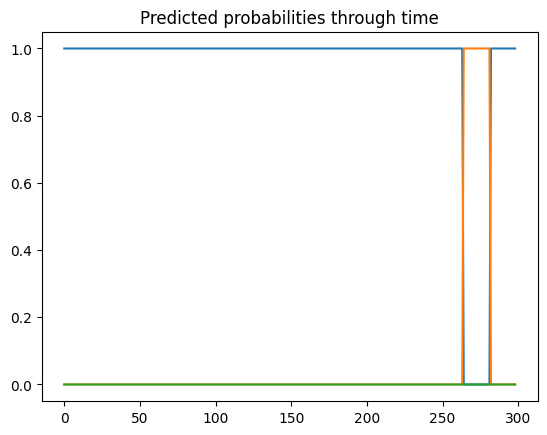

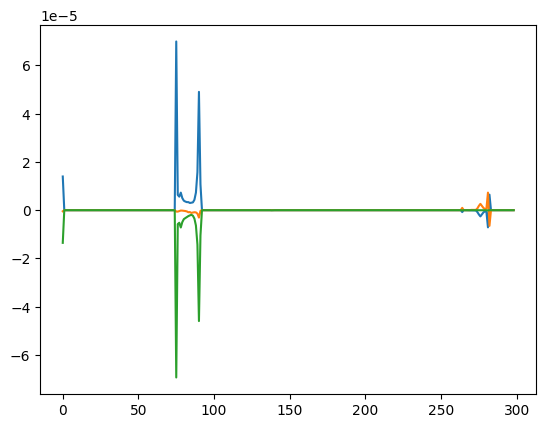

In [115]:
dc = decode_choice(d_o)
dc.shape
plt.plot(dc[0])
plt.title('Expected probabilities through time')
plt.show()

with torch.no_grad():
    pred_c = model(mod_in)
    plt.plot(pred_c[0])
    plt.title('Predicted probabilities through time') 
    plt.show()
    plt.plot(dc[0] - pred_c[0])
    plt.show()

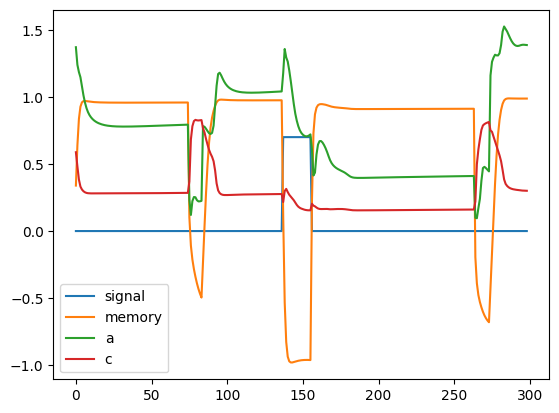

In [116]:
# dive into memory

with torch.no_grad():
    if typeCell == 'BEF': 
        packed = model.forward(x=mod_in, debug_mem=True)
        a,b,c,d,e,pred_c, slow_var = packed
        print(model.sense.forward(mod_in).shape)
    elif typeCell == 'BRC':
        a,c,pred_c = model.forward(x=mod_in, debug_mem=True)
    else:
        pred_c = model.forward(x=mod_in, debug_mem=True)
    # model.mem.ff_ha.weight = torch.nn.Parameter(u@torch.diag(s)@v)
    # pred_pc = model.forward(x=mod_in, debug_mem=True)

for i in range(0,128,128):
    plt.clf()
    plt.plot(mod_in[0,:,1], label = 'signal')
    plt.plot(pred_c[0,:,i], label= 'memory')
    # plt.plot(slow_var[0,:,i], label= 'slow_var')
    if typeCell != 'GRU':
        plt.plot(a[0,:,i], label= 'a')
        plt.plot(c[0,:,i], label= 'c')
        if typeCell == 'BEF':
            plt.plot(b[0,:,i], label= 'b')
            plt.plot(d[0,:,i], label= 'd')
            plt.plot(e[0,:,i], label= 'e')
    
    plt.legend()
    # plt.plot(pred_pc[0,:,i])
    plt.show()


### Generate animation of Phase plane as a function of timesteps for BEF cell

In [117]:
# Enable interactive plot
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
def make_BEF_phase_portrait_animation(model,input_signal,neuron_nb):
    # model needs to have a BEF memory cell
    # input signal of shape (Batch size,sequence length,2) 
    # neuron number <nb memory cells
    fig, ax = plt.subplots()
    with torch.no_grad():
        packed = model.forward(x=input_signal, debug_mem=True)
        a,b,c,d,e,fast_var, slow_var = packed

    hfs = torch.meshgrid(torch.linspace(-1.5,1.5, 100), torch.linspace(-.5,6,100), indexing = 'ij')
    hfs = torch.cat((hfs[0].unsqueeze(0), hfs[1].unsqueeze(0)))

    ax.set_xlim(-0.5, 6)
    ax.set_ylim(-1.5, 1.5)

    ## sense input 
    B, L, N = input_signal.shape  
    inputs = model.sense(input_signal.reshape((-1, N))).reshape((B,L,-1))

    ## define model
    def transition(hf, hs, pars):
        # size (B, V)
        a,b,c,d,e,x = pars['a'],pars['b'],pars['c'],pars['d'],pars['e'],pars['x']
        hfn = hf * (1-c) + c*torch.tanh(x + (a + b*hf**2 - hs)*hf) #0 input response
        hsn = hs*(1-d) + d*(e*hf)**4

        return hfn, hsn 

    def animate(frame_num):
        step_input = inputs[:,frame_num]
        in_emb  = model.mem.ff_im(step_input)
        _, _, _, _, _, neuron_inputs = in_emb.split(model.mem.mem_sz, 1)

        pars = {'a': a[0,frame_num,neuron_nb],
                'b': b[0,frame_num,neuron_nb],
                'c': c[0,frame_num,neuron_nb],
                'd': d[0,frame_num,neuron_nb],
                'e': e[0,frame_num,neuron_nb],
                'x': neuron_inputs[0,neuron_nb].item(),
                }

        hfn, hsn = transition(hfs[0], hfs[1], pars)
        ax.clear()
        ax.contourf(hfs[1], hfs[0], hfn - hfs[0], 0)
        ax.contour(hfs[1], hfs[0], hsn - hfs[1], 0)
        ax.set_title("neuron : "+ str(neuron_nb) + ", Time_step : " +  str(frame_num))
        
        # Plot trajectory
        ax.plot(slow_var[0, :frame_num, neuron_nb], fast_var[0, :frame_num, neuron_nb], 'r', alpha=0.5)
        ax.plot(slow_var[0, frame_num, neuron_nb], fast_var[0, frame_num, neuron_nb], 'ro')

    anim = FuncAnimation(fig, animate, frames=input_signal.shape[1],interval = 2,repeat = True, repeat_delay = 500)
    anim.save("phaseplot_animation_neuron" +str(neuron_nb) +".gif", writer='pillow')

def make_BEF_density_phase_portrait_animation(model,input_signal):
    # model needs to have a BEF memory cell
    # input signal of shape (Batch size,sequence length,2) 
    # neuron number <nb memory cells
    fig, ax = plt.subplots()
    with torch.no_grad():
        packed = model.forward(x=input_signal, debug_mem=True)
        a,b,c,d,e,fast_var, slow_var = packed

    hfs = torch.meshgrid(torch.linspace(-1.5,1.5, 100), torch.linspace(-.5,6,100), indexing = 'ij')
    hfs = torch.cat((hfs[0].unsqueeze(0), hfs[1].unsqueeze(0)))

    ax.set_xlim(-0.5, 6)
    ax.set_ylim(-1.5, 1.5)

    ## sense input 
    B, L, N = input_signal.shape  
    inputs = model.sense(input_signal.reshape((-1, N))).reshape((B,L,-1))
    
    alpha = 1 / memory_size
    ## define model
    def transition(hf, hs, pars):
        # size (B, V)
        a,b,c,d,e,x = pars['a'],pars['b'],pars['c'],pars['d'],pars['e'],pars['x']
        hfn = hf * (1-c) + c*torch.tanh(x + (a + b*hf**2 - hs)*hf)
        hsn = hs*(1-d) + d*(e*hf)**4

        return hfn, hsn 

    def animate(frame_num):
        step_input = inputs[:,frame_num]
        in_emb  = model.mem.ff_im(step_input)
        _, _, _, _, _, neuron_inputs = in_emb.split(model.mem.mem_sz, 1)
        ax.clear()
        for neuron in range(memory_size):
            pars = {'a': a[0,frame_num,neuron],
                    'b': b[0,frame_num,neuron],
                    'c': c[0,frame_num,neuron],
                    'd': d[0,frame_num,neuron],
                    'e': e[0,frame_num,neuron],
                    'x': neuron_inputs[0,neuron].item(),
                    }

            hfn, hsn = transition(hfs[0], hfs[1], pars)
            
            ax.contourf(hfs[1], hfs[0], hfn - hfs[0], 0, alpha = alpha)
            ax.contour(hfs[1], hfs[0], hsn - hfs[1], 0,alpha = alpha)
        ax.set_title("Time_step : " +  str(frame_num))
        
        # Plot trajectory
        for neuron in range(memory_size):
            ax.plot(slow_var[0, :frame_num, neuron], fast_var[0, :frame_num, neuron], 'r', alpha=0.5*alpha)
            ax.plot(slow_var[0, frame_num, neuron], fast_var[0, frame_num, neuron], 'ro',markersize=3)

    anim = FuncAnimation(fig, animate, frames=input_signal.shape[1],interval = 2,repeat = True, repeat_delay = 500)
    anim.save("densisty_phaseplot_animation.gif", writer='pillow')

#make_BEF_phase_portrait_animation(model,mod_in,32)
#make_BEF_density_phase_portrait_animation(model,mod_in)

In [118]:
def make_BRC_phase_portrait_animation(model,input_signal,neuron_nb):
    # model needs to have a BRC memory cell
    # input signal of shape (Batch size,sequence length,2) 
    # neuron number <nb memory cells
    fig, ax = plt.subplots()
    with torch.no_grad():
        a,c,fast_var = model.forward(x=mod_in, debug_mem=True)
    
    hfs = torch.meshgrid(torch.linspace(-5,5, 100), torch.linspace(-5,5,100), indexing = 'ij')
    hfs = torch.cat((hfs[0].unsqueeze(0), hfs[1].unsqueeze(0)))

    ## sense input 
    B, L, N = input_signal.shape  
    inputs = model.sense(input_signal.reshape((-1, N))).reshape((B,L,-1))

    ### draw the biffurcation diagram
    def get_ode(pars):
        _,c,x = pars['a'],pars['c'],pars['x']
        def f(a,hf):
            # return (c-1) *(hf - torch.tanh(x + a*hf))
            return c*hf + (1-c)*torch.tanh(x + a*hf) # this eq does not work and I don't really know why because they are suposed to be equivalent
        return f

    def animate(frame_num):
        step_input = inputs[:,frame_num]
        in_emb  = model.mem.ff_im(step_input)
        _, _, neuron_inputs = in_emb.split(model.mem.mem_sz, 1)
        
        ax.clear()

        pars = {'a': a[0,frame_num,neuron_nb],
                'c': c[0,frame_num,neuron_nb],
                'x': neuron_inputs[0,neuron_nb].item(),
                }
        
        func = get_ode(pars)
        ax.contourf(hfs[0],hfs[1], func(hfs[0],hfs[1]) - hfs[1], 0)
        
        ax.set_title("Time_step : " +  str(frame_num))
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        ax.set_xlabel("a")
        ax.set_ylabel("cell output")
        # Plot trajectory

        ax.plot(a[0,:frame_num, neuron_nb] ,fast_var[0, :frame_num, neuron_nb], 'r',alpha = 0.3)
        ax.plot(a[0,frame_num, neuron_nb], fast_var[0, frame_num, neuron_nb], 'ro',markersize=pars['c']*10)

    anim = FuncAnimation(fig, animate, frames=input_signal.shape[1],interval = 2,repeat = True, repeat_delay = 500)
    anim.save("biffurcation_BRC_animation_neuron"+str(neuron_nb)+".gif", writer='pillow')

def make_BRC_density_phase_portrait_animation(model,input_signal):
    # model needs to have a BRC memory cell
    # input signal of shape (Batch size,sequence length,2) 
    # neuron number <nb memory cells
    fig, ax = plt.subplots()
    with torch.no_grad():
        a,c,fast_var = model.forward(x=mod_in, debug_mem=True)
    
    hfs = torch.meshgrid(torch.linspace(-3,3, 300), torch.linspace(-3,3,300), indexing = 'ij')
    hfs = torch.cat((hfs[0].unsqueeze(0), hfs[1].unsqueeze(0)))

    ## sense input 
    B, L, N = input_signal.shape  
    inputs = model.sense(input_signal.reshape((-1, N))).reshape((B,L,-1))

    ### draw the biffurcation diagram
    def get_ode(pars):
        _,c,x = pars['a'],pars['c'],pars['x']
        def f(a,hf):
            # return (c-1) *(hf - torch.tanh(x + a*hf))
            return c*hf + (1-c)*torch.tanh(x + a*hf) # this eq does not work and I don't really know why because they are suposed to be equivalent
        return f

    alpha = 1 / memory_size
    def animate(frame_num):
        step_input = inputs[:,frame_num]
        in_emb  = model.mem.ff_im(step_input)
        _, _, neuron_inputs = in_emb.split(model.mem.mem_sz, 1)
        
        ax.clear()
        for neuron in range(memory_size):
            pars = {'a': a[0,frame_num,neuron],
                    'c': c[0,frame_num,neuron],
                    'x': neuron_inputs[0,neuron].item(),
                    }
            
            func = get_ode(pars)
            ax.contourf(hfs[0], hfs[1], func(hfs[0],hfs[1]) - hfs[1], 0, alpha = alpha)
            
        ax.set_title("Time_step : " +  str(frame_num))
        ax.set_xlabel("a")
        ax.set_ylabel("cell output")
        # Plot trajectory
        for neuron in range(memory_size):

            ax.plot(a[0,:frame_num, neuron] ,fast_var[0, :frame_num, neuron], 'r', alpha=alpha)
            ax.plot(a[0,frame_num, neuron], fast_var[0, frame_num, neuron], 'ro',markersize=pars['c']*5)

    anim = FuncAnimation(fig, animate, frames=input_signal.shape[1],interval = 2,repeat = True, repeat_delay = 500)
    anim.save("densisty_biffurcation_BRC_animation.gif", writer='pillow')

#make_BRC_density_phase_portrait_animation(model, mod_in)
#make_BRC_phase_portrait_animation(model, mod_in,10)

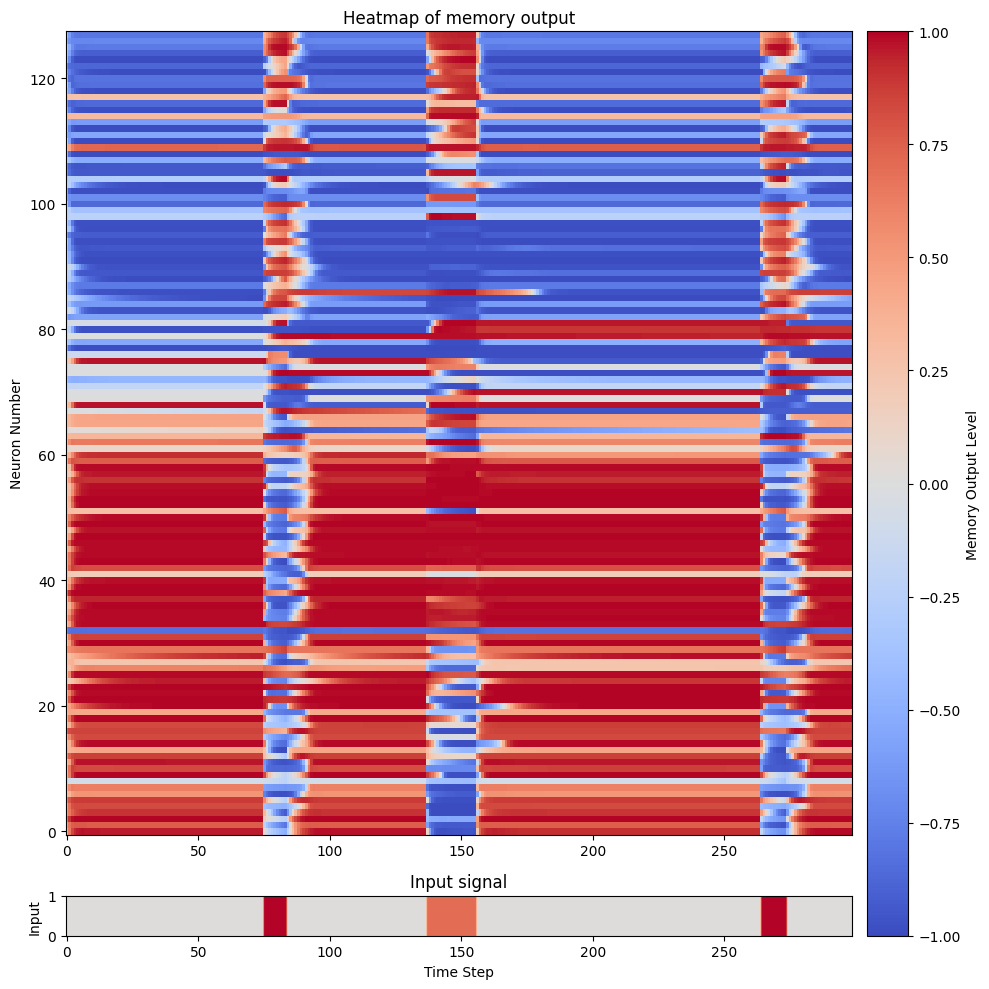

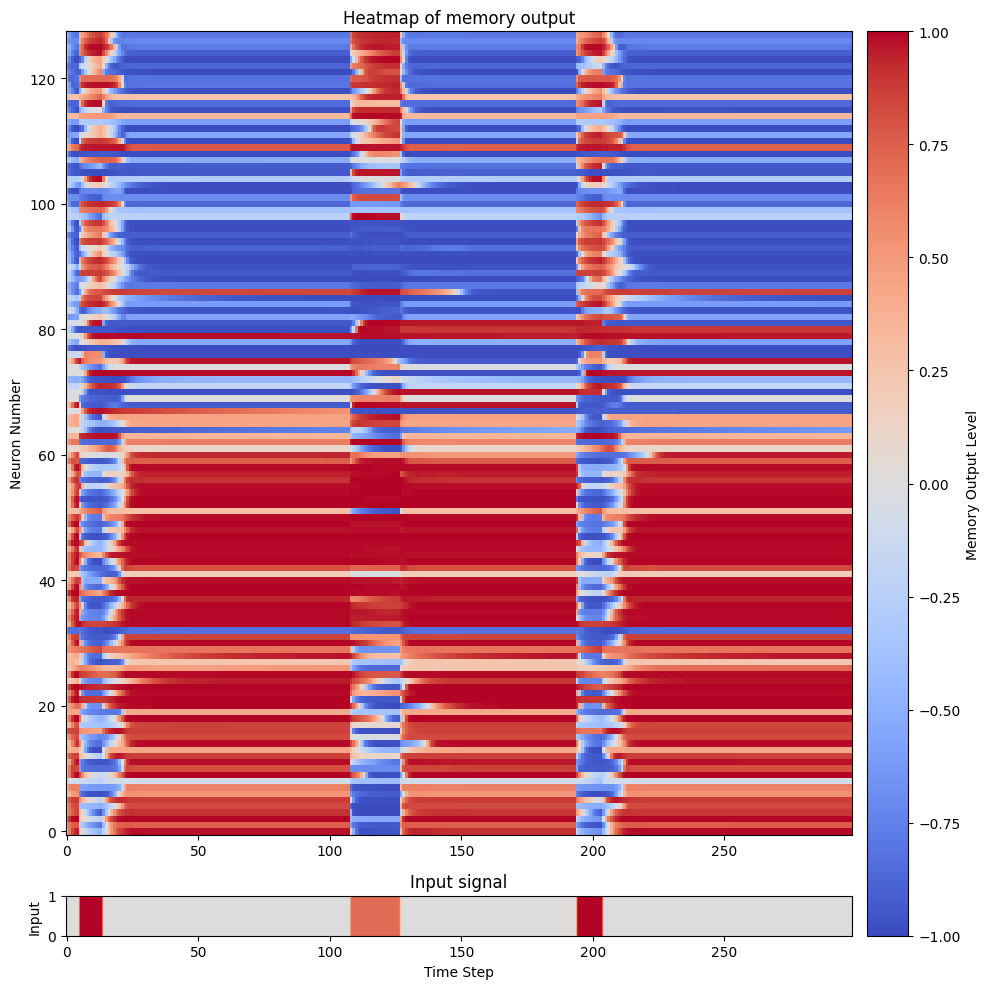

In [119]:
%matplotlib inline
from matplotlib.cm import ScalarMappable
import matplotlib.gridspec as gridspec

def plot_heatmap(pred_c, input_signal):
    # Get the shape of pred_c and input_signal
    num_timesteps, num_neurons = pred_c.shape

    # Create a meshgrid for the time steps and neuron numbers
    timesteps, neurons = np.meshgrid(range(num_timesteps), range(num_neurons))

    # Create subplots for both heatmaps
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(2, 2, width_ratios=[0.95, 0.05], height_ratios=[10, 0.5])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    cax = fig.add_subplot(gs[:, 1])

    # Plot pred_c heatmap
    pcm1 = ax1.pcolormesh(timesteps, neurons, pred_c.T, shading='auto', cmap='coolwarm', vmin = -1, vmax = 1)
    ax1.set_ylabel('Neuron Number')
    ax1.set_title('Heatmap of memory output')

    # Plot mod_in heatmap
    x = np.arange(num_timesteps)
    extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
    ax2.imshow(input_signal[np.newaxis,:], cmap="coolwarm", aspect="auto", extent=extent,vmin = -1, vmax = 1)
    #ax2.pcolormesh(np.arange(num_timesteps), input_signal, shading='auto', cmap='coolwarm', vmin = -1, vmax = 1)
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Input')
    ax2.set_title('Input signal')
    ax2.margins(x=0)
    # Add colorbar
    cbar = fig.colorbar(pcm1, cax=cax)
    cbar.set_label('Memory Output Level')

    plt.tight_layout()
    plt.show()
    
toOrder = pred_c[0].T
corr = torch.corrcoef(toOrder)
idx = corr[0].argsort(descending = True)
plot_heatmap(pred_c[0,:,idx],d_i[0])

plot_heatmap(pred_c[1,:,idx],d_i[1])



### PCA projections

In [120]:
from sklearn.decomposition import PCA

def perform_pca(data, n_components):
    pca = PCA(n_components=n_components, svd_solver = "full")
    pca.fit(data)
    transformed_data = pca.transform(data)
    pca_full = PCA(svd_solver = "full")
    pca_full.fit(data)
    return transformed_data, pca,pca_full.explained_variance_ratio_

def project_sample(sample, pca):
    transformed_sample = pca.transform(sample.reshape(1, -1))
    projected_sample = transformed_sample[:, :3]  # Take the first 3 principal components
    return projected_sample

#### Animation of one projection

In [121]:
def make_animation_PCA_trajectory(principal_components,anim_title = "principal_comp_trajectory.gif"):
    # Plot the 3D space with the projected sample
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111, projection='3d')
    ax1.plot([], [], [], c='b', label='Data')

    ax1.set_xlabel('PC 1')
    ax1.set_ylabel('PC 2')
    ax1.set_zlabel('PC 3')
    ax1.legend()
    
    PC1_max = max(principal_components[0, :])
    PC1_min = min(principal_components[0, :])
    PC2_max = max(principal_components[1, :])
    PC2_min = min(principal_components[1, :])
    PC3_max = max(principal_components[2, :])
    PC3_min = min(principal_components[2, :])
    def update(frame):
        ax1.clear()
        ax1.plot(principal_components[0, :frame], principal_components[1, :frame], principal_components[2, :frame], c='b', label='trajectory')
        ax1.set_xlabel('PC 1')
        ax1.set_ylabel('PC 2')
        ax1.set_zlabel('PC 3')
        ax1.set_xlim(PC1_min, PC1_max)
        ax1.set_ylim(PC2_min, PC2_max)
        ax1.set_zlim(PC3_min, PC3_max)

        ax1.set_title("trajectory time_step : " +  str(frame))
        ax1.legend()

    # Create the animation
    animation = FuncAnimation(fig1, update, frames=principal_components.shape[1], interval=100)
    animation.save(anim_title, writer='pillow')

    # Create a separate figure for the three component plots
    fig2  = plt.figure(figsize=(6, 10))
    ax2   = fig2.add_subplot() 
    # PC1 plot
    ax2.plot(np.arange(len(principal_components[0,:])),principal_components[0, :],  c='b', label = 'PC1')
    ax2.set_ylabel('Principal component value')
    ax2.set_xlabel('Data Index')

    # PC2 plot
    ax2.plot(np.arange(len(principal_components[0,:])),principal_components[1, :],  c='g',label = 'PC2')

    ax2.set_ylabel('PC2')
    

    # PC3 plot
    ax2.plot(np.arange(len(principal_components[0,:])),principal_components[2, :],  c='r',label = 'PC3')
    ax2.legend()
    fig2.show()
    return animation, fig2

transformed, pca_fitter, info_captured = perform_pca(pred_c[0,:,idx],3)
transformed = transformed.T
#make_animation_PCA_trajectory(t2)

##### Compare several trajectories

C:\Users\Aurélien B\AppData\Local\Temp\ipykernel_17392\2732875879.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
C:\Users\Aurélien B\AppData\Local\Temp\ipykernel_17392\2732875879.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
C:\Users\Aurélien B\AppData\Local\Temp\ipykernel_17392\1052748472.py:63: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


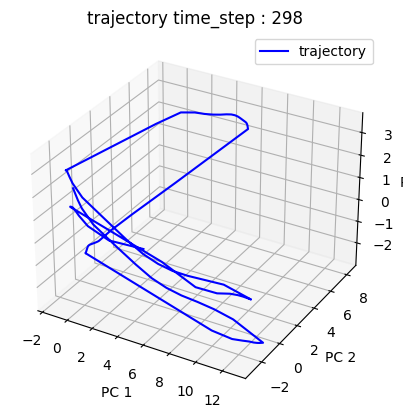

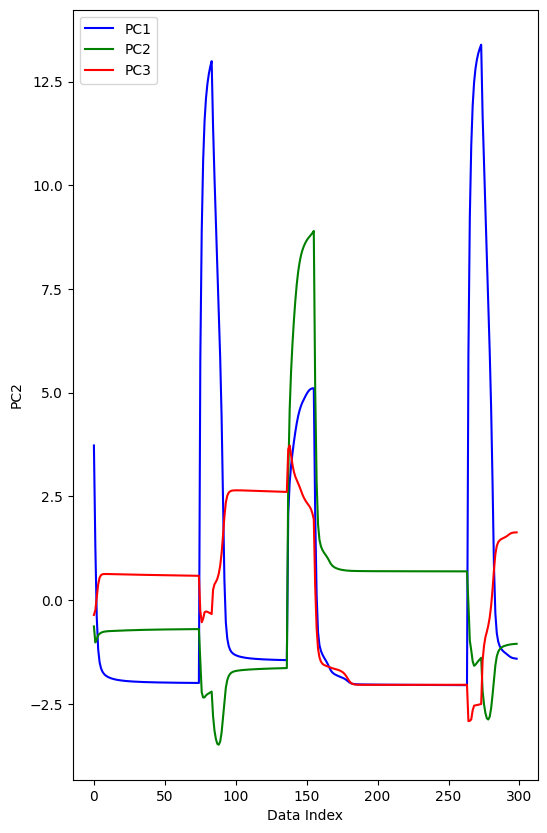

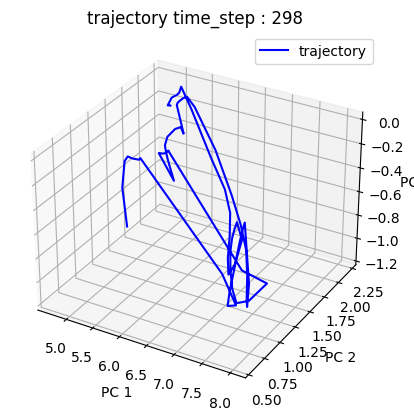

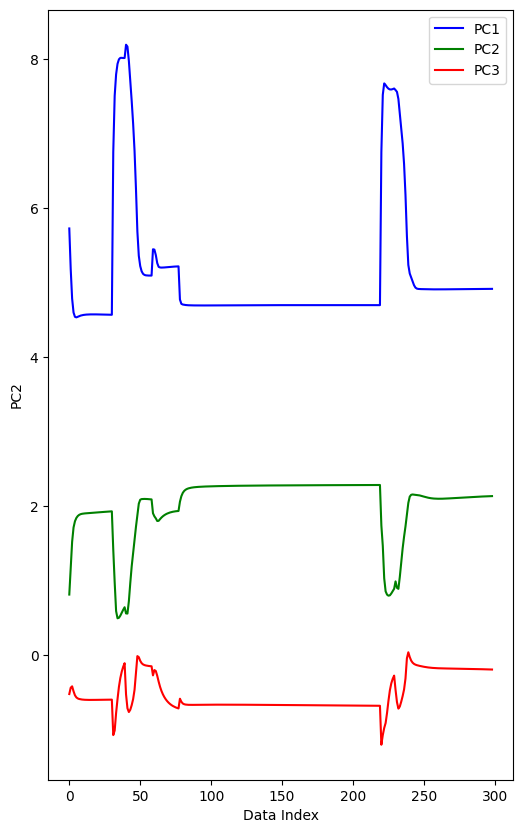

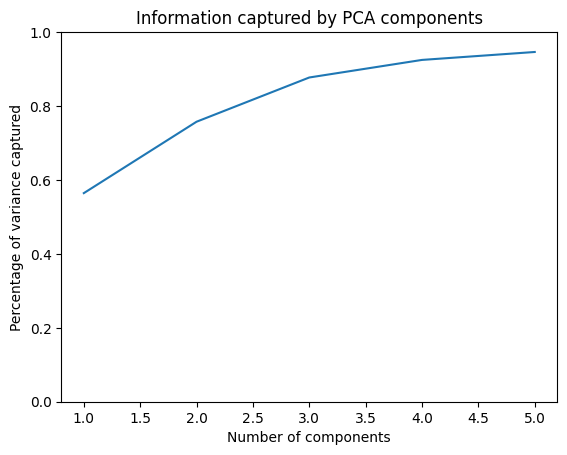

In [122]:
#high stim
stimG = StimGenerator(dt=.1)
d_i, d_o = stimG.get_batch_data(1,random=False,stim_type=False)
d_i, d_o = stimG.extend_sim(30, d_i, d_o)
B, L = d_i.shape
mod_in = torch.zeros((B,L,2))
mod_in[...,0][d_i == 1] = 1
mod_in[...,1][d_i != 1] = d_i[d_i!=1]

fast_var_high_stim = []
with torch.no_grad():
    if typeCell == 'BEF': 
        packed = model.forward(x=mod_in, debug_mem=True)
        a,b,c,d,e,fast_var_high_stim, slow_var = packed

    elif typeCell == 'BRC':
        a,c,fast_var_high_stim = model.forward(x=mod_in, debug_mem=True)
    else:
        fast_var_high_stim = model.forward(x=mod_in, debug_mem=True)
    # model.mem.ff_ha.weight = torch.nn.Parameter(u@torch.diag(s)@v)
    # pred_pc = model.forward(x=mod_in, debug_mem=True)

#Low stim
stimG = StimGenerator(dt=.1)
d_i, d_o = stimG.get_batch_data(1,random=False,stim_type=True)
d_i, d_o = stimG.extend_sim(30, d_i, d_o)
B, L = d_i.shape
mod_in = torch.zeros((B,L,2))
mod_in[...,0][d_i == 1] = 1
mod_in[...,1][d_i != 1] = d_i[d_i!=1]

fast_var_low_stim = []
with torch.no_grad():
    if typeCell == 'BEF': 
        packed = model.forward(x=mod_in, debug_mem=True)
        a,b,c,d,e,fast_var_low_stim, slow_var = packed

    elif typeCell == 'BRC':
        a,c,fast_var_low_stim = model.forward(x=mod_in, debug_mem=True)
    else:
        fast_var_low_stim = model.forward(x=mod_in, debug_mem=True)
    # model.mem.ff_ha.weight = torch.nn.Parameter(u@torch.diag(s)@v)
    # pred_pc = model.forward(x=mod_in, debug_mem=True)

transformed_high_response, pca_fitter_high_response, info_captured = perform_pca(pred_c[0,:,idx],3)
transformed_high_response = transformed_high_response.T
make_animation_PCA_trajectory(transformed_high_response,"high_Response_PCA anim.gif")

transformed_low_response = []
for i in range(L):
    transformed_low_response.append(project_sample(fast_var_low_stim[0,i,:],pca_fitter_high_response)[0])
transformed_low_response = np.array(transformed_low_response)

make_animation_PCA_trajectory(transformed_low_response.T,"low_Response_PCA anim.gif")

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.arange(1,6),np.cumsum(info_captured)[:5])
ax.set_ylabel('Percentage of variance captured')
ax.set_xlabel('Number of components')
ax.set_ylim(0, 1)
ax.set_title('Information captured by PCA components')
fig.show()

### Parameters analysis of the models

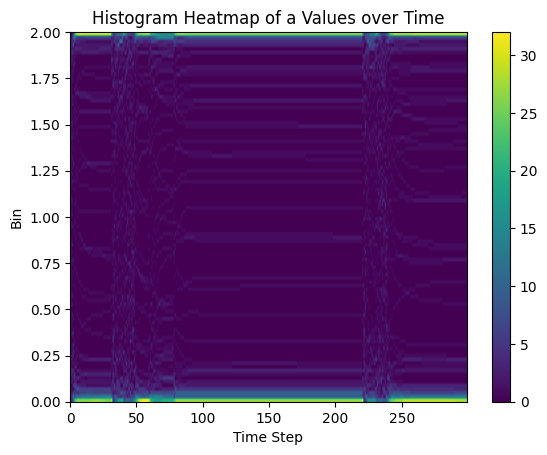

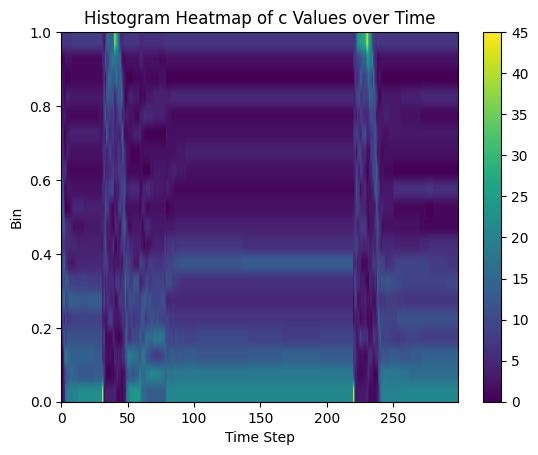

In [126]:
def create_histogram_heatmap(data,nb_bins = 20, par_range = [0,2], par_name = "parameter"):
    # Calculate the number of time steps
    num_time_steps = data.shape[0]

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create a colormap for the heatmaps
    cmap = plt.cm.viridis

    # Create a list to store the histograms
    histograms = []
    nb_bins
    # Iterate over each time step and create a histogram
    for i in range(num_time_steps):
        # Get the parameter values for the current time step
        values = data[i, :]
        # Create a histogram
        hist, bin_edges = np.histogram(values, bins=nb_bins, range=par_range)
        # Store the histogram
        histograms.append(hist)
        #print(hist)
        #print(bin_edges)
    # Convert the histograms to a numpy array
    histograms = np.array(histograms)

    # Plot the heatmap
    heatmap = ax.imshow(histograms.T, cmap=cmap,extent = [0,num_time_steps,par_range[0],par_range[1]] ,aspect='auto', origin='lower')

    # Set the labels and title
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Bin')
    ax.set_title('Histogram Heatmap of ' + par_name + ' Values over Time')

    # Create a colorbar
    cbar = plt.colorbar(heatmap)

    # Show the plot
    plt.show()
create_histogram_heatmap(a[0,:,:], nb_bins = 50, par_range = [0,2], par_name = 'a')
#create_histogram_heatmap(b[0,:,:],par_range = [0,3] , par_name = 'b')
create_histogram_heatmap(c[0,:,:],par_range = [0,1], par_name = 'c')
#create_histogram_heatmap(d[0,:,:],par_range = [0,0.3 * model.mem.dt], par_name = 'd')
#create_histogram_heatmap(e[0,:,:],par_range = [1,2], par_name = 'e')

### SVD tests

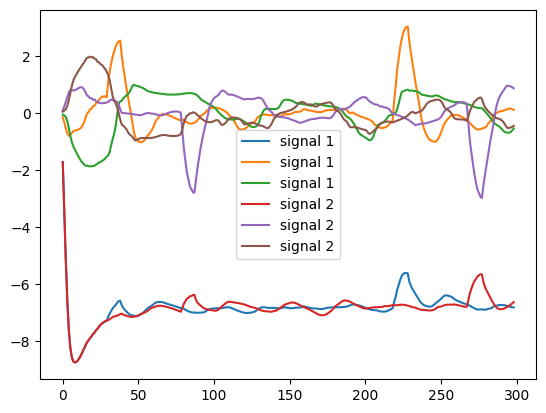

ModuleNotFoundError: No module named 'ipympl'

In [ ]:
%matplotlib inline
plt.close()
u,s,v = torch.svd(pred_c[0])

u1,s1,v1 = torch.svd(pred_c[1])

redTraj = (u[:,:3]@torch.diag(s[:3]))


redTraj1 = (u1[:,:3]@torch.diag(s1[:3]))


plt.plot(redTraj, label = 'signal 1')
plt.plot(redTraj1, label = 'signal 2')
plt.legend()
plt.show()


%matplotlib widget
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(redTraj[:,0], redTraj[:,1], redTraj[:,2])
ax.plot3D(redTraj1[:,0], redTraj1[:,1], redTraj1[:,2])
plt.show()
# plt.close()
# 

# from mpl_toolkits.mplot3d import Axes3D
 
# # creating figure
# fig = plt.figure()
# ax = Axes3D(fig)
 
# # creating the plot
# plot_geeks = ax.plot3D(redTraj[:,0], redTraj[:,1], redTraj[:,2], 'green')
 
# # setting title and labels
# ax.set_title("3D plot")
# ax.set_xlabel('x-axis')
# ax.set_ylabel('y-axis')
# ax.set_zlabel('z-axis')
 
# # displaying the plot
# plt.show()